# Matplotlib Animation
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [matplotlib_animation.ipynb](https://github.com/diegoinacio/creative-coding-notebooks/blob/master/Tips-and-Tricks/matplotlib_animation.ipynb)
---
Examples of animated visualization using *Matplotlib*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numba import jit
import imageio as iio
import os, sys

import matplotlib.animation as manim

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

## 1. Exporting image sequence
---

### 1.1. Color shifting
---

In [3]:
fig, (axA, axB) = plt.subplots(1, 2)

imgA = iio.imread('../_data/babuino.png')/255
frames = 4

for frame in range(frames):
    imgA = (imgA + frame/frames) % 1
    axA.imshow(imgA)

    axB.hist(imgA[..., 0].ravel(), bins=256, range=(0.0, 1.0), fc='r', alpha=0.5)
    axB.hist(imgA[..., 1].ravel(), bins=256, range=(0.0, 1.0), fc='g', alpha=0.5)
    axB.hist(imgA[..., 2].ravel(), bins=256, range=(0.0, 1.0), fc='b', alpha=0.5)
    
    plt.tight_layout()

    plt.savefig('output/matplotlib_animation_colorShift.{0:04d}.png'.format(frame))
    axA.cla(); axB.cla()

plt.close()

In [4]:
%%HTML
<table>
    <tr>
        <td><img src='output/matplotlib_animation_colorShift.0000.png' width="512"></td>
        <td><img src='output/matplotlib_animation_colorShift.0001.png' width="512"></td>
    </tr>
    <tr>
        <td><img src='output/matplotlib_animation_colorShift.0002.png' width="512"></td>
        <td><img src='output/matplotlib_animation_colorShift.0003.png' width="512"></td>
    </tr>
</table>

,
,


## 2. Exporting GIFs
---

Linux e OSX
``` python
>>> conda install --channel conda-forge imagemagick
```

For windows folow [ImageMagick download](https://imagemagick.org/script/download.php).

In [5]:
# windows user only
plt.rcParams["animation.convert_path"] = r"C:\Program Files\ImageMagick-7.0.10-Q16-HDRI\magick.exe"

### 2.1. Reaction-Diffusion system
---

In [6]:
@jit(nopython=True, parallel=True)
def nabla2f(Z):
    '''
    Laplace operator
    '''
    Zup = Z[0:-2,1:-1]
    Zdown = Z[2:,1:-1]
    Zleft = Z[1:-1,0:-2]
    Zright = Z[1:-1,2:]
    Zcenter = Z[1:-1,1:-1]
    return Zup + Zleft + Zdown + Zright - 4*Zcenter

@jit(nopython=True, parallel=True)
def reactionDiffusion(U, V, u, v, ru, rv, f, k, iters):
    '''
    Reaction diffusion system
    '''
    for i in range(iters):
        u += ru*nabla2f(U) - u*v**2 + f*(1 - u)
        v += rv*nabla2f(V) + u*v**2 - (f + k)*v
    return V

In [7]:
fig, ax = plt.subplots(figsize=(2048//72, 512//72))

# gif parameters
N1, N2 = 128j, 512j
M1, M2 = int(N1.imag), int(N2.imag)
iters = 70
frames = 30

# RD system initialization
np.random.seed(sum(map(lambda c: ord(c), 'reaction diffusion')))
U = np.zeros((M1 + 2, M2 + 2)); u = U[1:-1, 1:-1]
V = np.zeros((M1 + 2, M2 + 2)); v = V[1:-1, 1:-1]
t, s = np.mgrid[-0.25:0.25:N1, -1:1:N2]
fo = 5
u += np.sin(np.pi*s*fo)*np.sin(np.pi*t*fo) >= 2**0.5/2
v += np.cos(np.pi*s*fo)*np.cos(np.pi*t*fo) >= 2**0.5/2
e = 0.4
u += np.random.random((M1, M2))*e - e
v += np.random.random((M1, M2))*e - e

f, k, ru, rv = 0.06, 0.062, 0.19, 0.05

def animation(frame):
    plt.cla(); #ax.set_ylim(-1, 1); ax.set_title('White Noise')
    RD = reactionDiffusion(U, V, u, v, ru, rv, f, k, iters)
    imshow = ax.imshow(RD, vmin=RD.min(), vmax=RD.max())
    plt.tight_layout()
    return imshow

anim = manim.FuncAnimation(fig, animation, frames=30, interval=100)

anim.save('output/matplotlib_animation_reactionDiffusion.gif', writer="imagemagick", extra_args="convert")
plt.close()

# Solve repetition problem
! magick convert _output/matplotlib_animation_reactionDiffusion.gif -loop 0 _output/matplotlib_animation_reactionDiffusion.gif
! echo GIF exported and reconverted. Disregard the message above.

convert: unable to open image '_output/matplotlib_animation_reactionDiffusion.gif': No such file or directory @ error/blob.c/OpenBlob/3537.
convert: no images defined `_output/matplotlib_animation_reactionDiffusion.gif' @ error/convert.c/ConvertImageCommand/3285.


GIF exported and reconverted. Disregard the message above.


![Reaction Diffusion](output/matplotlib_animation_reactionDiffusion.gif)

## 3. Exporting videos
---

``` python
>>> conda install --channel conda-forge ffmpeg
```

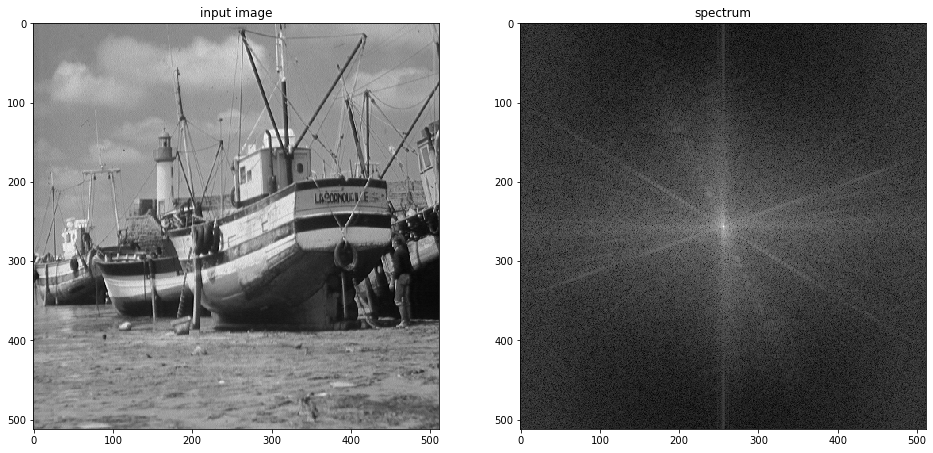

In [8]:
img = iio.imread('../_data/ship.png')/255
IMG = np.fft.fft2(img)
IMG = np.fft.fftshift(IMG)

fig, (axA, axB) = plt.subplots(1, 2)

axA.imshow(img, cmap='gray')
axA.set_title('input image')

axB.imshow(np.log10(1 + abs(IMG)), cmap='gray')
axB.set_title('spectrum')

plt.show()

### 3.1. Band-pass filter
---

In [9]:
t, s = np.mgrid[-1:1:512j, -1:1:512j]
d = (s**2 + t**2)**0.5
f = lambda mu, sigma: 1/(sigma*(2*np.pi)**0.5)*np.exp(-1/2*((d - mu)/sigma)**2)

FFMpegWriter = manim.writers['ffmpeg']
metadata = dict(title='Band-pass filter', artist='Diego Inácio',
                comment='Exporting movies using Python and Matplotlib')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, (axA, axB) = plt.subplots(1, 2)

mu, sigma = -0.5, 0.1
frames = 90
with writer.saving(fig, 'output/matplotlib_animation_BPF.mp4', frames):
    for i in range(frames):
        H = f(mu, sigma)
        axA.imshow(H, cmap='gray')
        axA.set_title(r'filter H, $\sigma={0}$, $\mu={1:.2f}$'.format(sigma, mu))

        img_H = np.fft.ifftshift(H*IMG)
        img_H = np.fft.ifft2(img_H).real
        axB.imshow(img_H, cmap='gray')
        axB.set_title('filtered image')
        
        mu += 2/frames
        writer.grab_frame()
        print('{:06.2f} %'.format(100*(i + 1)/frames), end='\r', flush=True)
plt.close()

In [10]:
%%HTML
<video width='900' height='450' controls>
  <source src='output/matplotlib_animation_BPF.mp4' type='video/mp4'>
</video>